# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

In [1]:
%matplotlib inline

import os
from pathlib import Path

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.svm
import sklearn.utils

import utils.fma_extraction as fma_extraction

plt.rcParams["figure.figsize"] = (17, 5)

In [2]:
# Directory where mp3 are stored.
FMA_METADATA_DIRECTORY = os.getenv("FMA_METADATA_DIRECTORY")
FMA_AUDIO_DIRECTORY = os.getenv("FMA_AUDIO_DIRECTORY")

# Load metadata and features.
tracks = fma_extraction.load(Path(FMA_METADATA_DIRECTORY) / "tracks.csv")
genres = fma_extraction.load(Path(FMA_METADATA_DIRECTORY) / "genres.csv")
features = fma_extraction.load(Path(FMA_METADATA_DIRECTORY) / "features.csv")
echonest = fma_extraction.load(Path(FMA_METADATA_DIRECTORY) / "echonest.csv")

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [ ]:
ipd.display(tracks["track"].head())
ipd.display(tracks["album"].head())
ipd.display(tracks["artist"].head())
ipd.display(tracks["set"].head())

### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [ ]:
small = tracks[tracks["set", "subset"] <= "small"]
small.shape

In [ ]:
medium = tracks[tracks["set", "subset"] <= "medium"]
medium.shape

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [ ]:
print("{} top-level genres".format(len(genres["top_level"].unique())))
genres.loc[genres["top_level"].unique()].sort_values("#tracks", ascending=False)

In [ ]:
genres.sort_values("#tracks").head(10)

## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [ ]:
print("{1} features for {0} tracks".format(*features.shape))
columns = ["mfcc", "chroma_cens", "tonnetz", "spectral_contrast"]
columns.append(["spectral_centroid", "spectral_bandwidth", "spectral_rolloff"])
columns.append(["rmse", "zcr"])
for column in columns:
    ipd.display(features[column].head().style.format("{:.2f}"))

### 3.1 Echonest features

In [ ]:
print("{1} features for {0} tracks".format(*echonest.shape))
ipd.display(echonest["echonest", "metadata"].head())
ipd.display(echonest["echonest", "audio_features"].head())
ipd.display(echonest["echonest", "social_features"].head())
ipd.display(echonest["echonest", "ranks"].head())

In [ ]:
ipd.display(echonest["echonest", "temporal_features"].head())
x = echonest.loc[2, ("echonest", "temporal_features")]
plt.plot(x)

### 3.2 Features like MFCCs are discriminant

((3551, 2), (3551,))

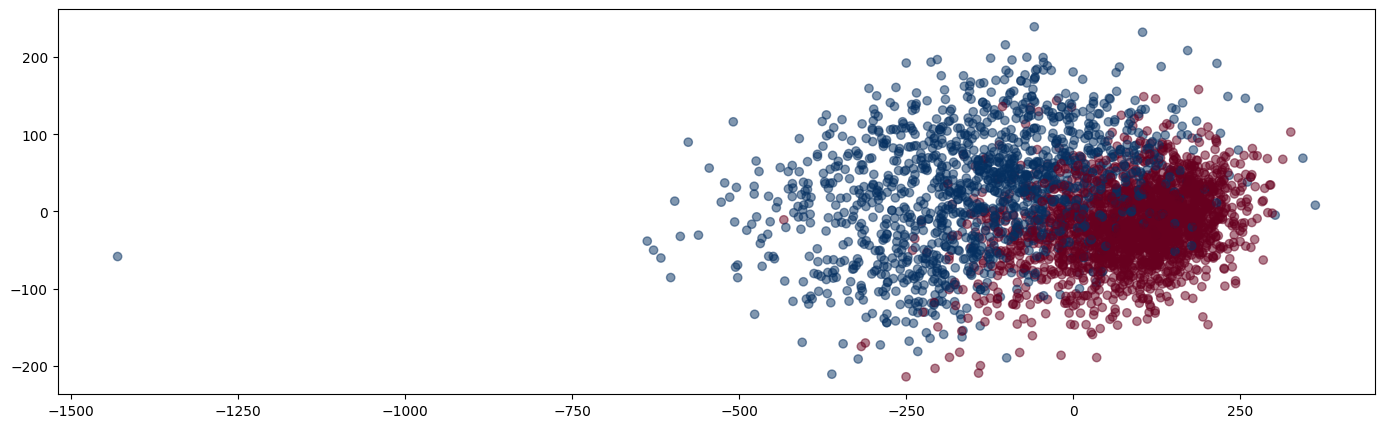

In [28]:
medium = tracks["set", "subset"] <= "medium"
genre1 = tracks["track", "genre_top"] == "Instrumental"
genre2 = tracks["track", "genre_top"] == "Hip-Hop"

X = features.loc[medium & (genre1 | genre2), "mfcc"]
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[medium & (genre1 | genre2), ("track", "genre_top")]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [29]:
filename = fma_extraction.get_audio_path(FMA_AUDIO_DIRECTORY, 2)
print(f"File: {filename}")

x, sr = librosa.load(filename, sr=None, mono=True)
print(f"Duration: {x.shape[-1] / sr:.2f}s, {x.size} samples")

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /Users/saavedj/Downloads/music/fma_medium/000/000002.mp3
Duration: 29.98s, 1321967 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

(-1.0, 1.0)

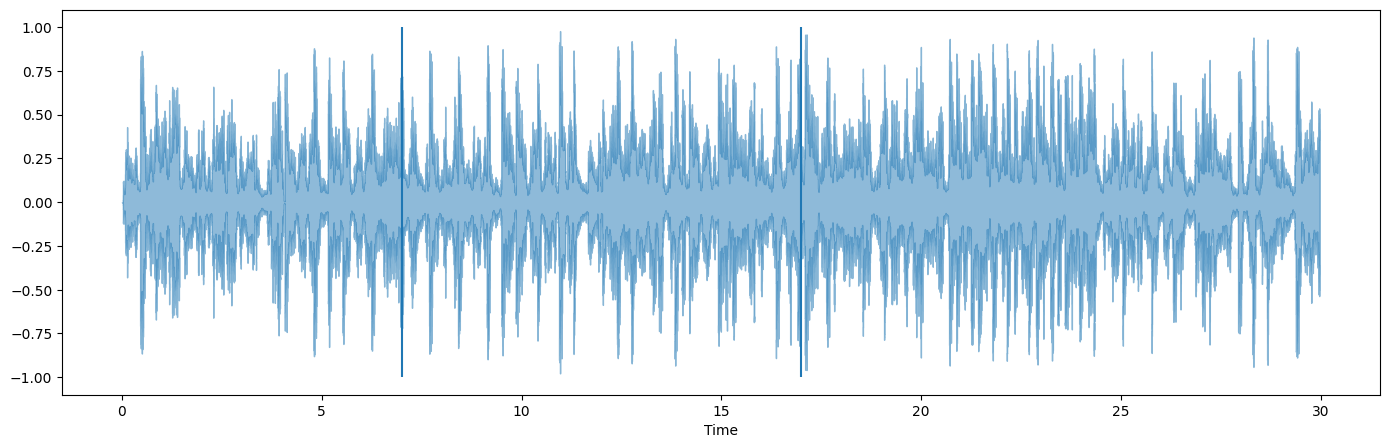

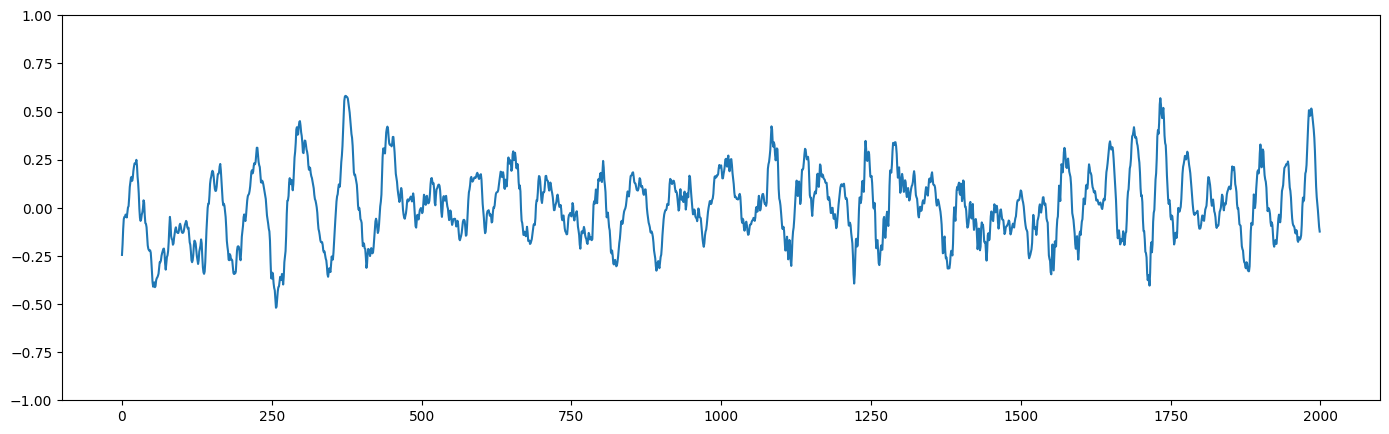

In [30]:
librosa.display.waveshow(y=x, sr=sr, alpha=0.5)
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1))

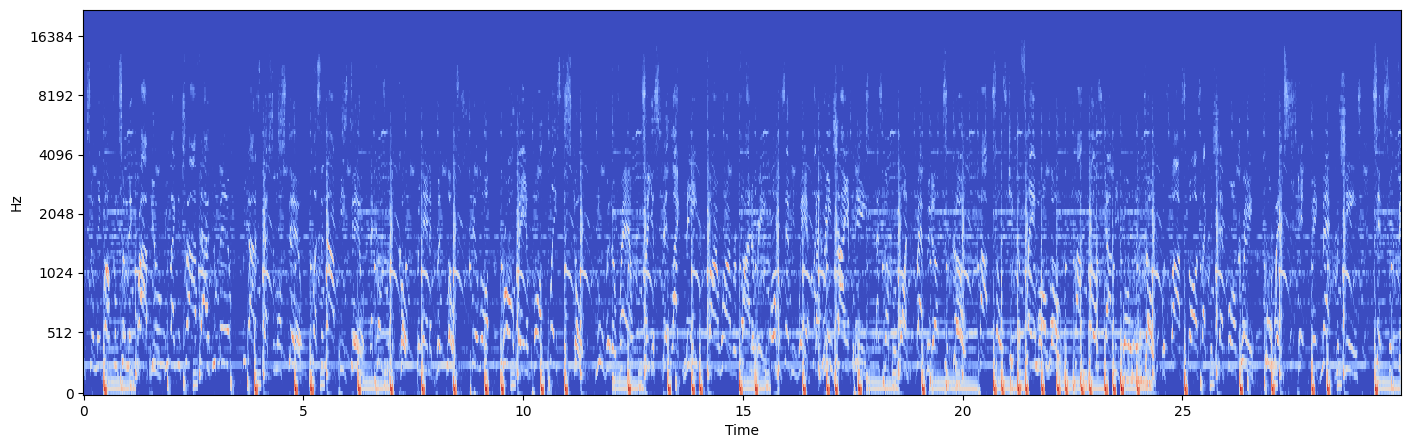

In [31]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis="time", y_axis="mel")

In [ ]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis="time");

## 5 Genre classification

### 5.1 From features

In [32]:
small = (tracks["set", "subset"] <= "medium")  # Filters for rows where the subset is "small"

# Create a boolean mask for the training, validation, and test data (where "set" is "training/validation/test")
train = tracks["set", "split"] == "training"
val = tracks["set", "split"] == "validation"
test = tracks["set", "split"] == "test"

# Select the genre labels (target) for the training set from the "small" subset and "training" split
y_train = tracks.loc[small & train, ("track", "genre_top")]
# Select the genre labels (target) for the testing set from the "small" subset and "test" split
y_test = tracks.loc[small & test, ("track", "genre_top")]
# Select the feature values (MFCCs) for the training set from the "small" subset and "training" split
X_train = features.loc[small & train, "mfcc"]
# Select the feature values (MFCCs) for the testing set from the "small" subset and "test" split
X_test = features.loc[small & test, "mfcc"]  # Filters for MFCC features (X) for testing

print(f"{y_train.size} training examples, {y_test.size} testing examples")
print(f"{X_train.shape[1]} features, {np.unique(y_train).size} classes")

19922 training examples, 2573 testing examples
140 features, 16 classes


In [ ]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy: {score:.2%}")